## Ames housing cost prediction

Data set contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('AmesHousing.xls',na_values=['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']
                     ,keep_default_na=False)

In [4]:
data = data.drop(columns=['Order','PID'])

In [5]:
data_y = data[['SalePrice']]
data_x = data.drop(columns=['SalePrice'],axis=1)

In [136]:
cont = data_x.select_dtypes(exclude=['object'])
cont_col = list(cont.columns)

## Visualization

Following is the visualization of the distribution of continuous variables. I notice that there is a wide range of scales in which the data is distributed. Lot of variables are peaked. Year is considered continuous in this assignment, though I feel it should be categorical. On using any models involving distance computation, this dataset should be scaled to get best results.

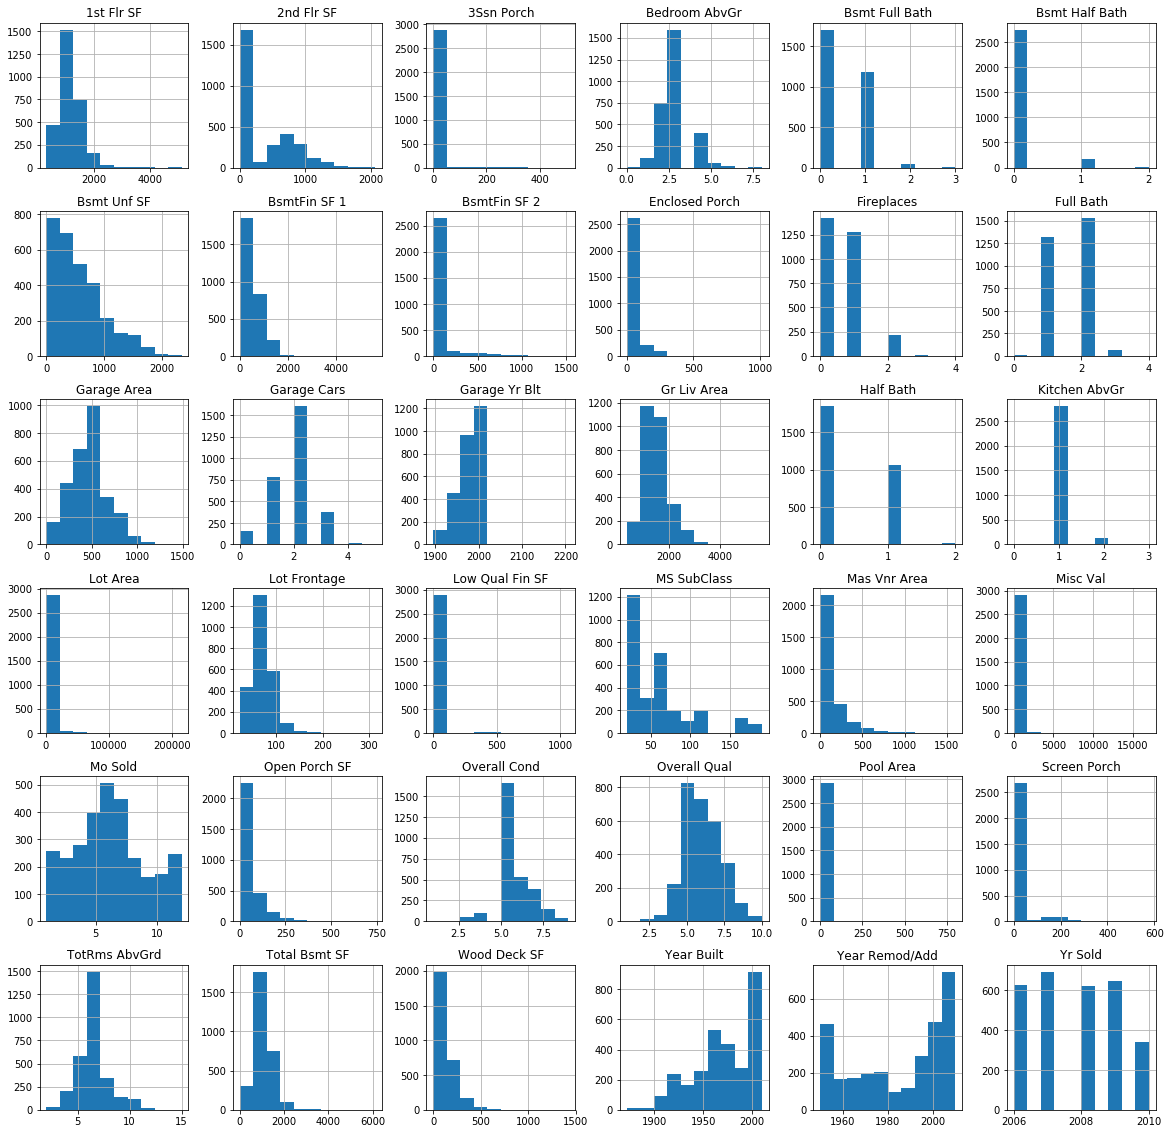

In [9]:
fig = cont.hist(figsize=(20,20))

Following is the visualization of the continuous variables with the target. It can be seen that many variables below can be best described as categorical rather than continuous, but for this assignment, I am proceeding with this.

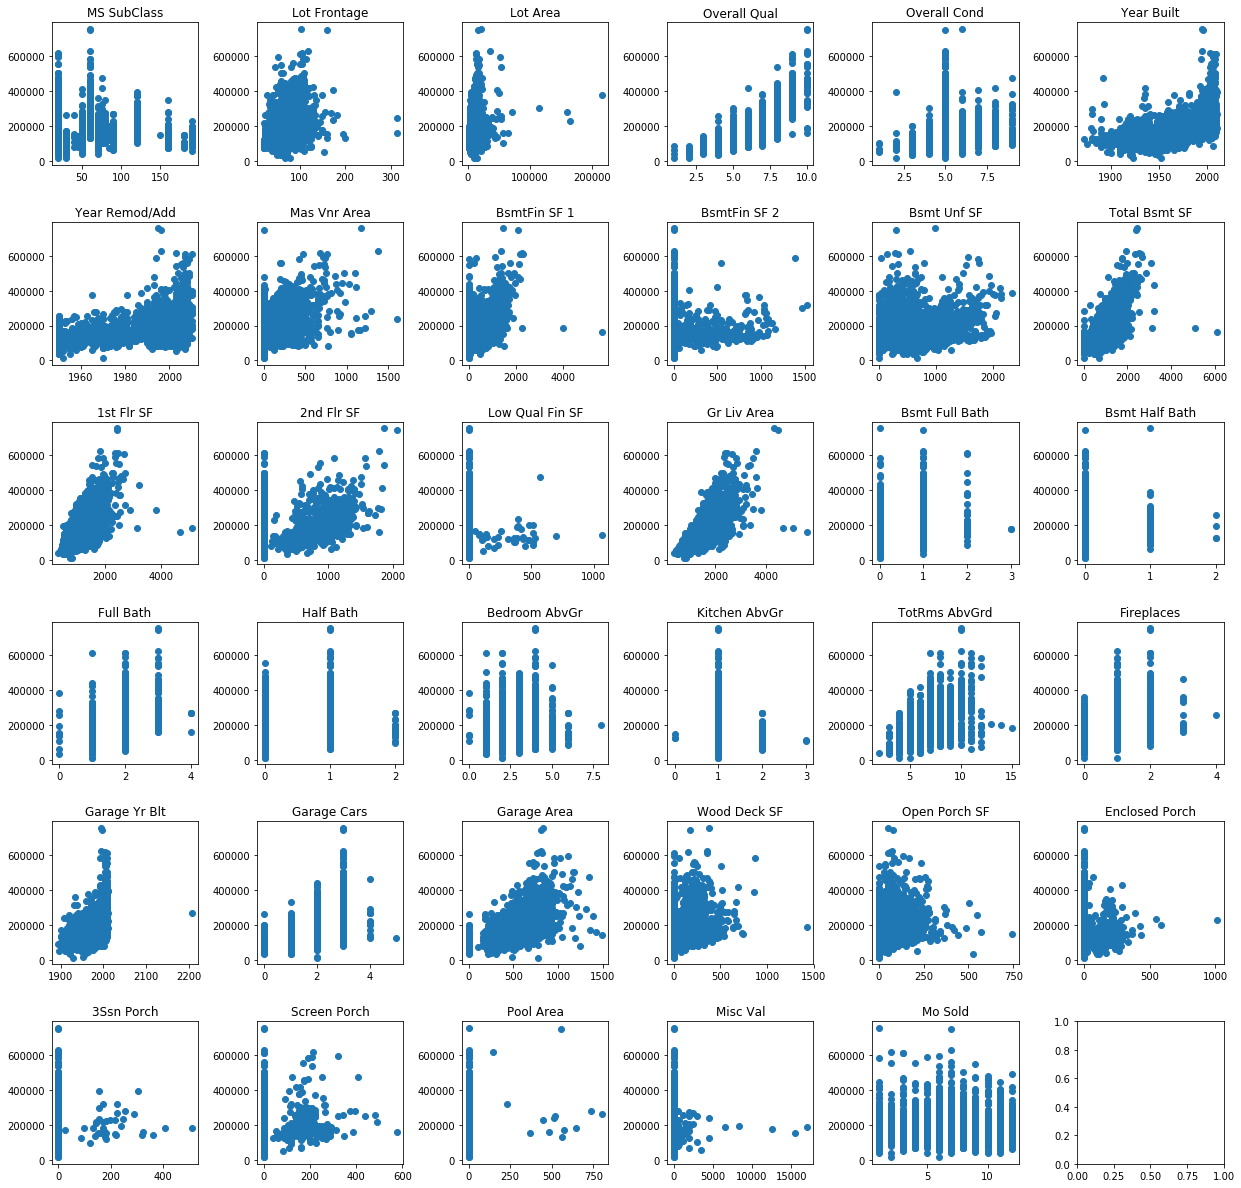

In [146]:
fig, ax = plt.subplots(6,6,figsize=(21,21))
fig.subplots_adjust(wspace=0.4,hspace=0.4)
n = 0
for i in range(0,6):
    for j in range(0,6):
        if n != 35:
            #ax[i,j].scatter(cont[data_x.columns[n]],data_y)
            ax[i,j].scatter(cont.iloc[:,n],data_y)
            ax[i,j].set_title(cont_col[n])
            n=n+1

## Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y)

In [15]:
X_train_cont = X_train.select_dtypes(exclude=['object'])
X_train_cat = X_train.select_dtypes(include=['object'])

In [17]:
len(list(X_train_cont.columns))
len(list(X_train_cat.columns))

43

In [18]:
cont_index = X_train_cont.columns
cat_index = X_train_cat.columns

Following is the code for imputation of the missing continuous variables. I am imputing those with mean values.

In [19]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="mean").fit(X_train_cont)
X_train_cont = imp.transform(X_train_cont)
X_train_cont = pd.DataFrame(X_train_cont,columns=cont_index)

The categorical variables are imputed with most frequent categories.

In [20]:
imp1 = SimpleImputer(strategy="most_frequent").fit(X_train_cat)
X_train_cat = imp1.transform(X_train_cat)
X_train_cat = pd.DataFrame(X_train_cat,columns=cat_index)

Following is the code to one hot encode the categorical columns

In [22]:
from sklearn.preprocessing import OneHotEncoder

#ohe_cat = OneHotEncoder().fit_transform(X_train_cat)

ohe = []

for c in range(0,len(X_train_cat.columns)):
    ohe.append(OneHotEncoder().fit_transform(X_train_cat.iloc[:,c].values.reshape(-1,1)))


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

#scores = cross_val_score(LinearRegression(),ohe_cat,y_train)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = []
    for i in ohe:
        scores.append((cross_val_score(LinearRegression(),i,y_train,scoring='r2')).mean())

In [24]:
print(sorted(range(len(scores)), key=lambda i: scores[i])[-3:])

[18, 21, 8]


In [25]:
print(list(X_train_cat.columns)[8],
list(X_train_cat.columns)[21],
list(X_train_cat.columns)[18])

Neighborhood Bsmt Qual Exter Qual


Neighborhood, Basement Quality and External Quality are the top 3 variables that have best R^2 value with the target.

Neighborhood has the highest R^2 value with the target.

Text(0, 0.5, 'Saleprice')

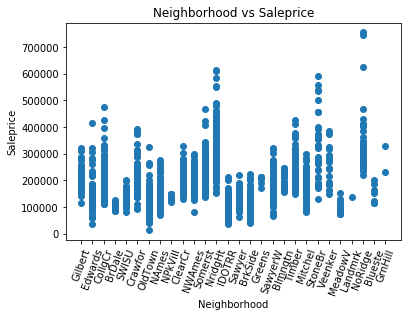

In [27]:
plt.xticks(rotation=70)
plt.scatter(X_train_cat.loc[:,'Neighborhood'],y_train.loc[:,'SalePrice'])
plt.title("Neighborhood vs Saleprice")
plt.xlabel("Neighborhood")
plt.ylabel("Saleprice")

Basement quality is the second highest feature.

Text(0, 0.5, 'Saleprice')

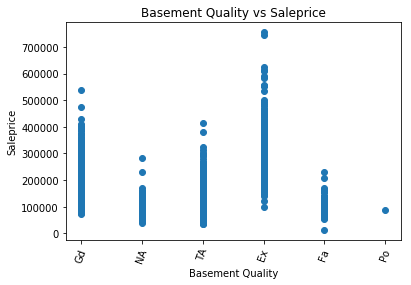

In [28]:
plt.xticks(rotation=70)
plt.scatter(X_train_cat.loc[:,'Bsmt Qual'],y_train.loc[:,'SalePrice'])
plt.title("Basement Quality vs Saleprice")
plt.xlabel("Basement Quality")
plt.ylabel("Saleprice")

Text(0, 0.5, 'Saleprice')

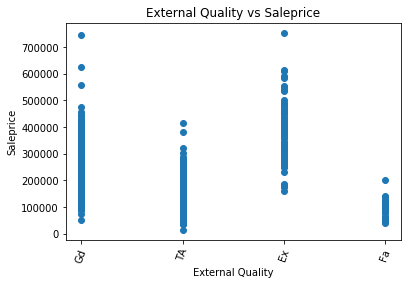

In [29]:
plt.xticks(rotation=70)
plt.scatter(X_train_cat.loc[:,'Exter Qual'],y_train.loc[:,'SalePrice'])
plt.title("External Quality vs Saleprice")
plt.xlabel("External Quality")
plt.ylabel("Saleprice")

## Fitting models

Fitting and training models without scaling

In [30]:
import numpy as np
X_train_cat1=X_train.select_dtypes(include=object).fillna('None')
X_train_cont1=X_train.select_dtypes(exclude=object)

X_train_cat1 = pd.DataFrame(X_train_cat1,columns=cat_index)

X_train = pd.concat([X_train_cont1,X_train_cat1],axis=1)

In [32]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
        
    preprocess = make_column_transformer((SimpleImputer(strategy='median'),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')
    
    pipe_lr = make_pipeline(preprocess,LinearRegression())
    pipe_r = make_pipeline(preprocess,Ridge())
    pipe_l = make_pipeline(preprocess,Lasso())
    pipe_en = make_pipeline(preprocess,ElasticNet())

    scores_lr = cross_val_score(pipe_lr, X_train, y_train)
    scores_r = cross_val_score(pipe_r, X_train, y_train)
    scores_l = cross_val_score(pipe_l, X_train, y_train)
    scores_en = cross_val_score(pipe_en, X_train, y_train)

In [34]:
print("linear regression mean score : " + str(scores_lr.mean()))
print("ridge regression mean score : " + str(scores_r.mean()))
print("lasso regression mean score : " + str(scores_l.mean()))
print("elasticnet regression mean score : " + str(scores_en.mean()))

linear regression mean score : 0.8154630017744
ridge regression mean score : 0.6576688902048219
lasso regression mean score : 0.8092201384080365
elasticnet regression mean score : 0.7832392896500245


Following is the code that scales the data and runs models

In [38]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    pipe_cont = make_pipeline(SimpleImputer(strategy='mean',missing_values=np.nan),
                                         (StandardScaler()))
    
    preprocess = make_column_transformer((pipe_cont,~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

    pipe_lr = make_pipeline(preprocess,LinearRegression())
    pipe_r = make_pipeline(preprocess,Ridge())
    pipe_l = make_pipeline(preprocess,Lasso())
    pipe_en = make_pipeline(preprocess,ElasticNet())



In [39]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores_lr = cross_val_score(pipe_lr, X_train, y_train)
    scores_r = cross_val_score(pipe_r, X_train, y_train)
    scores_l = cross_val_score(pipe_l, X_train, y_train)
    scores_en = cross_val_score(pipe_en, X_train, y_train)

In [40]:
print("linear regression mean score : " + str(scores_lr.mean()))
print("ridge regression mean score : " + str(scores_r.mean()))
print("lasso regression mean score : " + str(scores_l.mean()))
print("elasticnet regression mean score : " + str(scores_en.mean()))

linear regression mean score : 0.8047444571678627
ridge regression mean score : 0.8297685573032118
lasso regression mean score : 0.8093500430836906
elasticnet regression mean score : 0.8026733107965383


From the above results, it is seen that scaling does not influence the results except in ridge regression. Distance based models such as KNN are influenced by scaling. 

## Grid Search

In [41]:
from sklearn.model_selection import GridSearchCV
import numpy as np

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    a = []
    for i in range(1,25):
        a.append(i)
    param_r = {'ridge__alpha': np.array(a)}
    param_l = {'lasso__alpha': np.logspace(-3, 0, 13)}
    param_en = {'elasticnet__alpha': np.logspace(-4, -1, 10),
              'elasticnet__l1_ratio': [0.01, .1, .5, .9, .98, 1]}
    
    gs_r = GridSearchCV(estimator=pipe_r,param_grid=param_r)
    gs_r.fit(X_train,y_train)
    print(gs_r.best_params_)
    print(gs_r.best_score_)
    
    gs_l = GridSearchCV(estimator=pipe_l,param_grid=param_l)
    gs_l.fit(X_train,y_train)
    print(gs_l.best_params_)
    print(gs_l.best_score_)
    
    gs_en = GridSearchCV(estimator=pipe_en,param_grid=param_en)
    gs_en.fit(X_train,y_train)
    print(gs_en.best_params_)
    print(gs_en.best_score_)
    
    


{'ridge__alpha': 4}
0.8310135962117445
{'lasso__alpha': 1.0}
0.809326063656197
{'elasticnet__alpha': 0.004641588833612777, 'elasticnet__l1_ratio': 0.5}
0.8310076983440423


Elastic net has improved after grid search. Ridge and Lasso did not improve much.

In [132]:
def get_model_df(best_est,coef):
    cat_list = best_est.named_steps['columntransformer'].named_transformers_['onehotencoder'].categories_
    flat_list = [item for cat_list in cat_list for item in cat_list]
    cont = X_train.select_dtypes(exclude=['object'])
    tot_col = list(cont.columns)
    tot_col.extend(flat_list)
    df = pd.DataFrame({'cat':tot_col,'coeff':coef[0]})
    return df.reindex(df.coeff.abs().sort_values(ascending = False).index)
    

## Plotting top 10 ridge coefficients with features

Text(0.5, 1.0, 'Ridge features Vs coefficients')

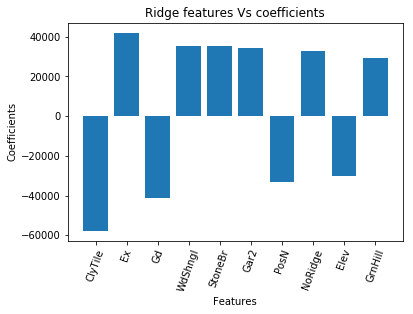

In [133]:
ridge_df = get_model_df(gs_r.best_estimator_,gs_r.best_estimator_.named_steps['ridge'].coef_)
plt.xticks(rotation=70)
plt.bar(ridge_df.iloc[:10,0],ridge_df.iloc[:10,1])
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Ridge features Vs coefficients")

## Plotting top 10 lasso coefficients with features

Text(0.5, 1.0, 'Lasso features Vs coefficients')

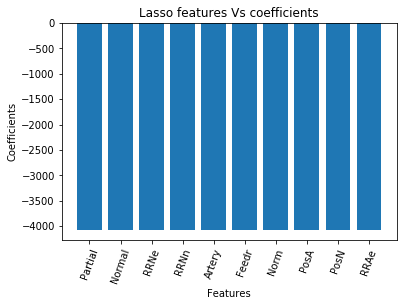

In [138]:
lasso_df = get_model_df(gs_l.best_estimator_,gs_l.best_estimator_.named_steps['lasso'].coef_)
plt.xticks(rotation=70)
plt.bar(lasso_df.iloc[:10,0],lasso_df.iloc[:10,1])
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Lasso features Vs coefficients")

In [86]:
h = gs_l.best_estimator_.named_steps['lasso'].coef_

(320,)


Text(0.5, 1.0, 'Lasso features Vs coefficients')

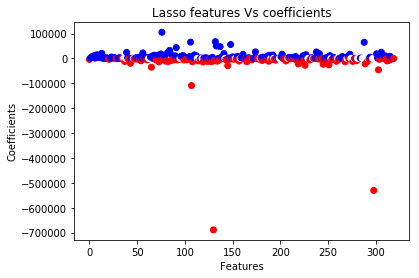

In [139]:
plt.scatter(range(320),h,c=np.sign(h),cmap="bwr_r")
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Lasso features Vs coefficients")

## Elastic net coefficients

Text(0.5, 1.0, 'Elastic Net features Vs coefficients')

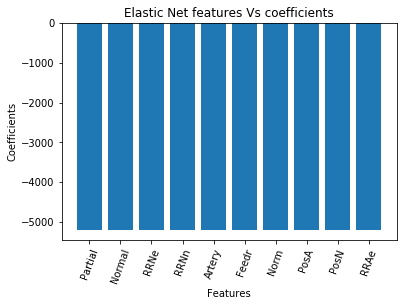

In [124]:
en_df = get_model_df(gs_en.best_estimator_,gs_en.best_estimator_.named_steps['elasticnet'].coef_)
plt.xticks(rotation=70)
plt.bar(en_df.iloc[:10,0],en_df.iloc[:10,1])
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Elastic Net features Vs coefficients")

The top 10 important features and coefficients are plotted. Lasso and elastic net appear the same whereas ridge differs from these two.

In [120]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    results_r = pd.DataFrame(gs_r.cv_results_)
    results_l = pd.DataFrame(gs_l.cv_results_)
    results_en = pd.DataFrame(gs_en.cv_results_)

Text(0.5, 1.0, 'parameter Vs score for ridge regression')

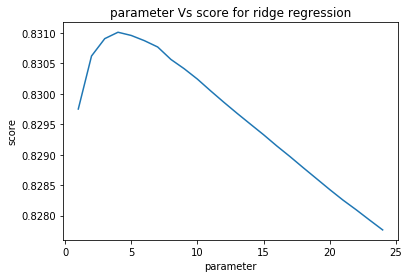

In [121]:
plt.plot(np.array(a),results_r[['mean_test_score']])
plt.xlabel("parameter")
plt.ylabel("score")
plt.title("parameter Vs score for ridge regression")

It can be seen that after a particular alpha value of about 5, the score decreases.

Visualization for lasso regression

Text(0.5, 1.0, 'parameter Vs score for lasso regression')

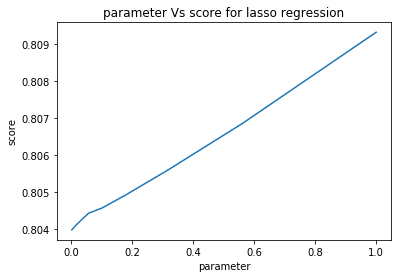

In [122]:
plt.plot(np.logspace(-3, 0, 13),results_l[['mean_test_score']])
plt.xlabel("parameter")
plt.ylabel("score")
plt.title("parameter Vs score for lasso regression")

The above graph shows that as the alpha parameter increases, the score increases.

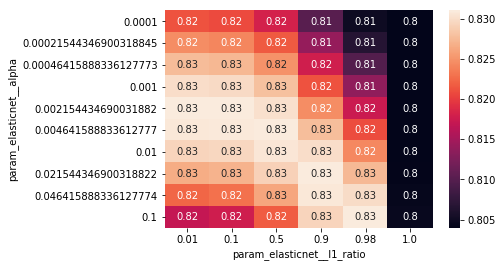

In [123]:
import seaborn as sns
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = pd.pivot_table(pd.DataFrame(gs_en.cv_results_),
        values='mean_test_score', index='param_elasticnet__alpha', columns='param_elasticnet__l1_ratio')
    ax = sns.heatmap(res,annot=True)

It can be evidently seen from the above graph that scores of 0.83 are achieved in l1 ratio ranges between 0.5 - 0.98 and corresponding alpha values in the range 0.046-0.0004 (as in the diagram).